# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 
import seaborn as sns
from sklearn.cluster import KMeans

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name='OfferInformation')
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name='Transactions')
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [4]:
df_customers = pd.merge_ordered (df_transactions, df_offers, how='outer', on='offer_id')
df = pd.pivot_table(df_customers, values='n', index='customer_name', columns='offer_id', aggfunc='count', fill_value=0)
df.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
Allen,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
Anderson,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
Bailey,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Baker,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

#### What values of  𝑆𝑆  do you believe represent better clusterings? Why?

The smaller values of SS represent better clusterings. The smaller the SS, the closer the data points are to their respective centroids.

In [5]:
x_cols = np.matrix(df[1:])

In [6]:
kmeans = KMeans()
clusters_pred = kmeans.fit_transform(x_cols)

In [7]:
ks = range(2,11)
ss = []
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(x_cols)
    ss.append(kmeans.inertia_)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

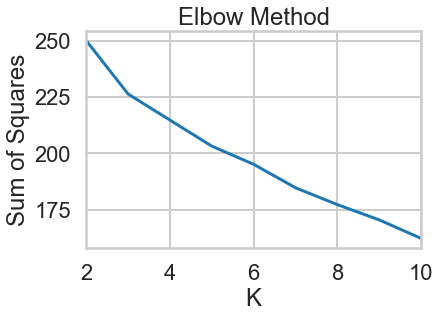

In [8]:
_ = plt.plot(ks, ss)
_ = plt.xlim([2,10])
_ = plt.xlabel('K')
_ = plt.ylabel('Sum of Squares')
_ = plt.title('Elbow Method')

In [9]:
# best k = 3 
clusters_pred = KMeans(n_clusters=3, random_state=1).fit_predict(x_cols)

0    36
1    16
2    47
dtype: int64

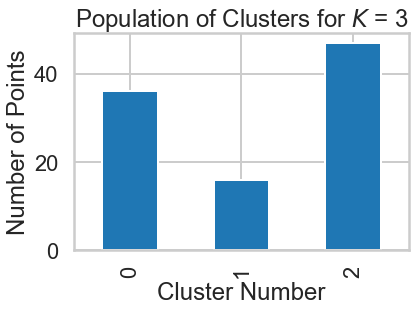

In [10]:
cluster_population = pd.Series(clusters_pred).value_counts().sort_index()
cluster_population

_ = cluster_population.plot(kind='bar')
_ = plt.xlabel('Cluster Number')
_ = plt.ylabel('Number of Points')
_ = plt.title('Population of Clusters for $K$ = 3')

### Answer:###
The Elbow Method was challenging since the figure does not display one clear elbow. It seems that one could also choose K = 3, 5, or 8.

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

For n_clusters = 2 The average silhouette_score is: 0.0903464103083123
For n_clusters = 3 The average silhouette_score is: 0.11922182861233044
For n_clusters = 4 The average silhouette_score is: 0.12643419351562143
For n_clusters = 5 The average silhouette_score is: 0.12252388025254604
For n_clusters = 6 The average silhouette_score is: 0.11646020956051405
For n_clusters = 7 The average silhouette_score is: 0.12342896118651267
For n_clusters = 8 The average silhouette_score is: 0.12791820088369635
For n_clusters = 9 The average silhouette_score is: 0.1327415091764174
For n_clusters = 10 The average silhouette_score is: 0.1329231117405359


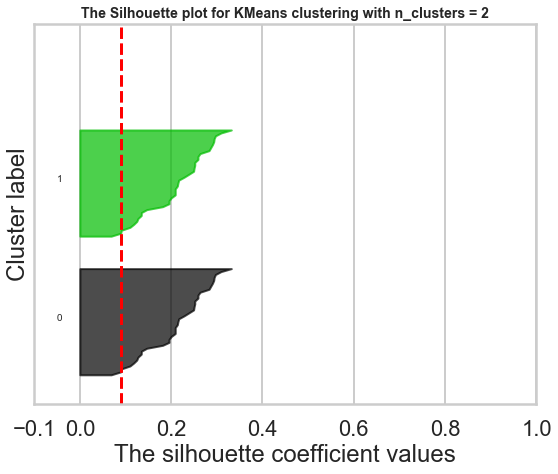

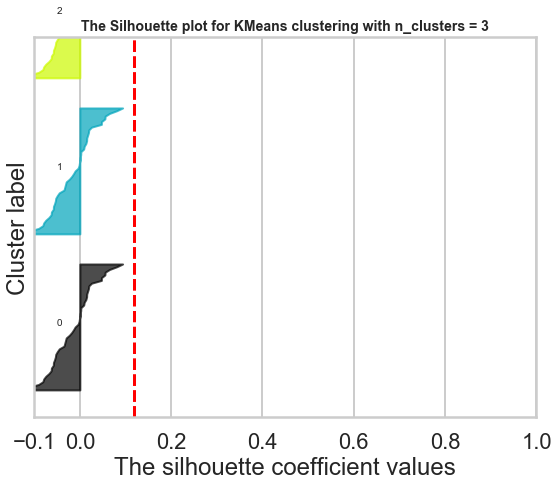

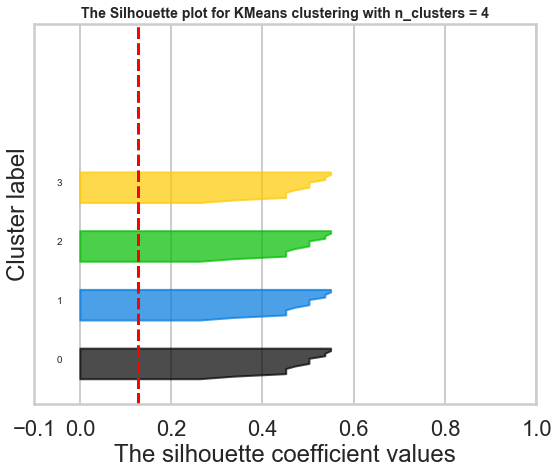

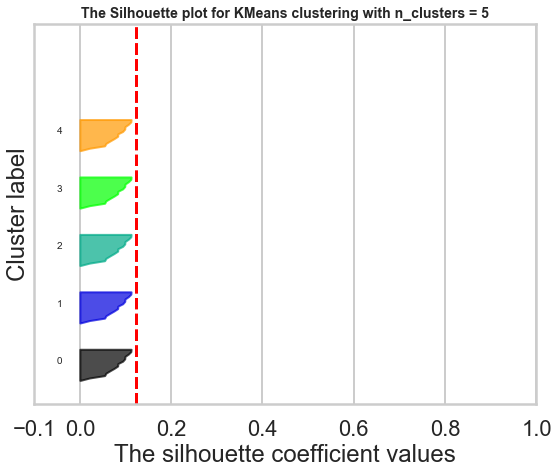

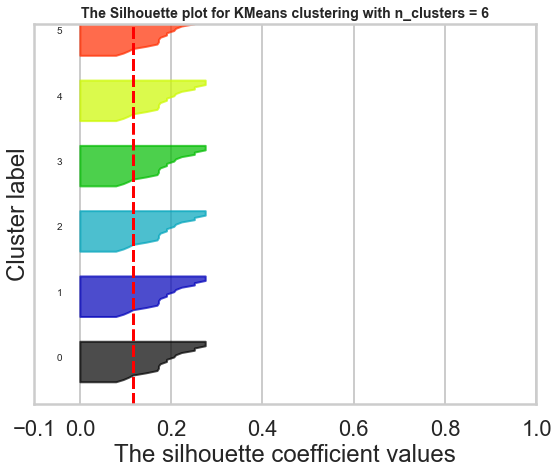

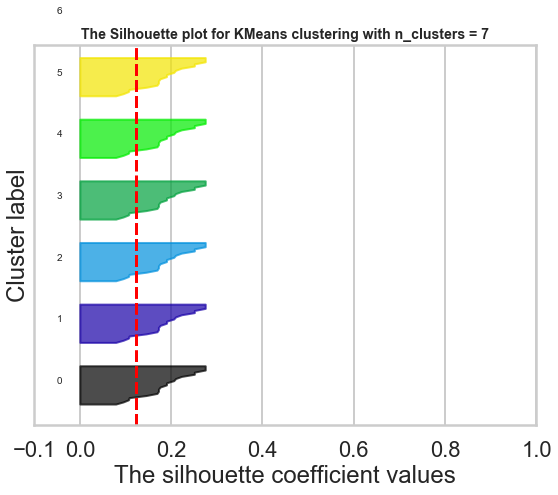

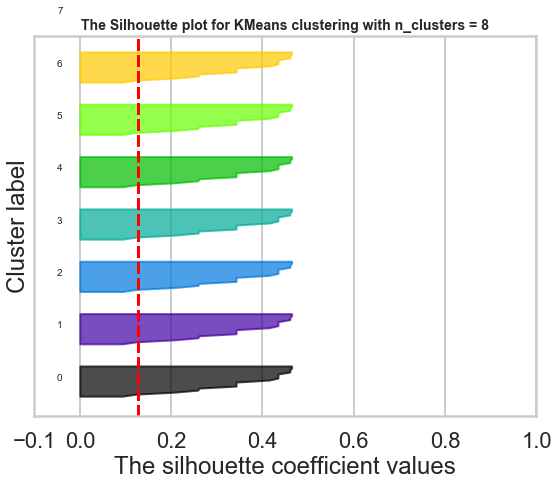

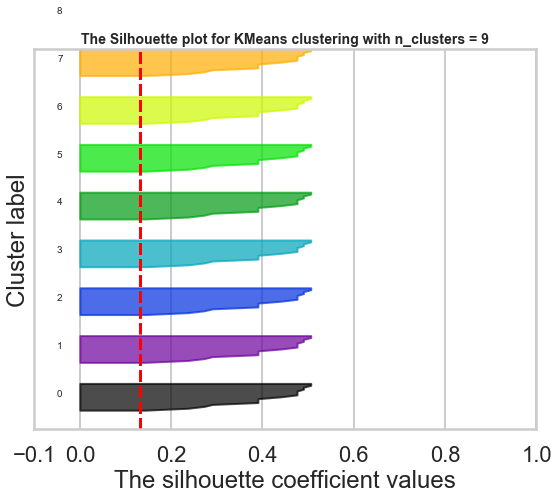

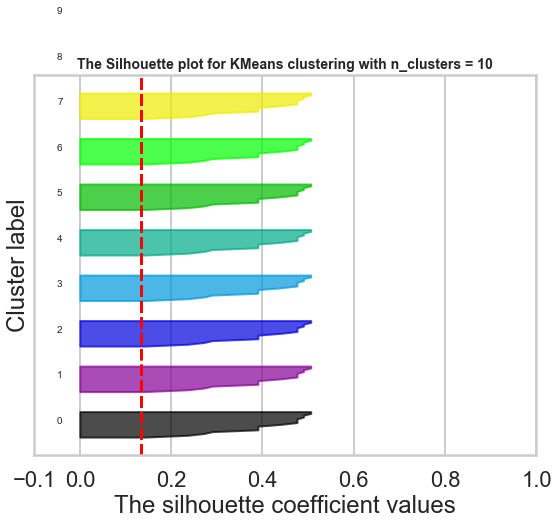

In [11]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = range(2,11)
silhouette_avgscores = []

for n_clusters in range_n_clusters:
    # Creating a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1,1)
    _ = fig.set_size_inches(9,7)
    
    # The silhouette coefficient can range from -1, 1 but in this example, all lie within [-0.1, 1]
    _ = ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters to demarcate them clearly
    _ = ax1.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])
    
    # Initialize the clusterer with n_clusters value and a random generator
    # Seed = 10 for reproducibility
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(x_cols)
    
    # The silhouette_score give the average value for all the samples
    # This gives perspective into the density and separate of forward clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    silhouette_avgscores.append(silhouette_avg)
    print("For n_clusters =", n_clusters, "The average silhouette_score is:", silhouette_avg)
    
    # Computing the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == 1]
        
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / n_clusters)
        _ = ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        
        # Label the silhouette plots with their cluster number at the middle
        _ = ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10 # 10 for the next 0 samples
        
        _ = ax1.set_title(("The Silhouette plot for KMeans clustering with n_clusters = %d" % n_clusters), fontsize=14, fontweight='bold')
        _ = ax1.set_xlabel("The silhouette coefficient values")
        _ = ax1.set_ylabel("Cluster label")
    
    # The vertical line for average silhouette score of all the values 
        _ = ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
        
        _ = ax1.set_yticks([]) #Clear the y-axis labels / ticks
        _ = ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

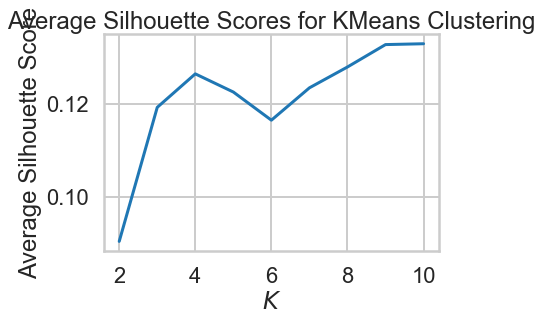

In [12]:
_ = plt.plot(range_n_clusters, silhouette_avgscores)
_ = plt.xlabel('$K$')
_ = plt.ylabel('Average Silhouette Score')
_ = plt.title('Average Silhouette Scores for KMeans Clustering')

### Answer: ###
The Silhouette Method suggests that we should use K = 10. This is different from the Elbow Method. Since 10 is at the edge of our test-value range, we should expand our test range.

D:\Anaconda\lib\site-packages\sklearn\cluster\_k_means.py:1007: ConvergenceWarning: Number of distinct clusters (88) found smaller than n_clusters (89). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
D:\Anaconda\lib\site-packages\sklearn\cluster\_k_means.py:1007: ConvergenceWarning: Number of distinct clusters (88) found smaller than n_clusters (90). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
D:\Anaconda\lib\site-packages\sklearn\cluster\_k_means.py:1007: ConvergenceWarning: Number of distinct clusters (88) found smaller than n_clusters (91). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
D:\Anaconda\lib\site-packages\sklearn\cluster\_k_means.py:1007: ConvergenceWarning: Number of distinct clusters (88) found smaller than n_clusters (92). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


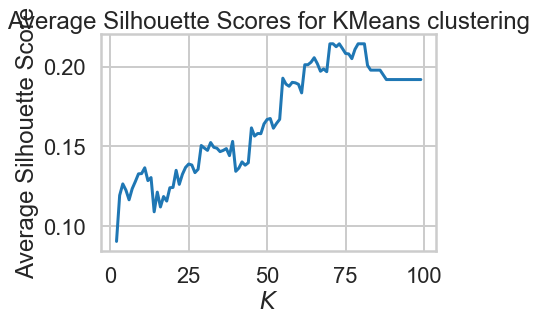

In [15]:
range_n_clusters = range(2, 100)
silhouette_avgscores = []

for n_clusters in range_n_clusters:
    
    # Initialize the clusterer with n_clusters value and a random generator
    # Seed = 10 for reproducibility
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(x_cols)
    
    # The silhouette_score give the average value for all the samples
    # This gives perspective into the density and separate of forward clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    silhouette_avgscores.append(silhouette_avg)
    #     print("For n_clusters =", n_clusters,
    #     "The average silhouette_score is :", silhouette_avg)
_ = plt.plot(range(2,100),silhouette_avgscores)
_ = plt.xlabel('$K$')
_ = plt.ylabel('Average Silhouette Score')
_ = plt.title('Average Silhouette Scores for KMeans clustering')

In [16]:
np.max(silhouette_avgscores)
np.argmax(silhouette_avgscores)

0.21439574493317257

69

### Answer:###
Having expanded our range of $K$s, we find that the Silhouette Method gives a best value of $K$ = 69. This seems a very large number of clusters. 

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [18]:
#your turn
# Initialize a PCA with 2 components
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

# Build a dataframe
df_pca = pd.DataFrame(np.array(df.index))

# Initialize clusterer using 3 clusters, fit and predict on x_cols
clusterer = KMeans(n_clusters=3, random_state=10)
clusterer.fit_predict(x_cols)

# Continue building dataframe
df_pca['cluster_label'] = pd.DataFrame(clusterer.fit_predict(x_cols)) 
df_pca['x'] = pd.DataFrame(pca.fit_transform(x_cols)).iloc[:,0]
df_pca['y'] = pd.DataFrame(pca.fit_transform(x_cols)).iloc[:,1]
df_pca.columns = ['customer_name', 'cluster_label', 'x', 'y']
df_pca

array([1, 2, 0, 0, 1, 2, 0, 1, 0, 1, 2, 0, 1, 0, 2, 1, 2, 0, 1, 0, 0, 1,
       1, 2, 1, 1, 1, 1, 2, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 2, 2, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 0, 2, 0, 0, 1, 1, 0, 1, 0, 0, 2, 2,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 2, 0, 0, 2, 1, 1, 1, 2, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1])

,customer_name,cluster_label,x,y
0,Adams,1.0,-0.277613,0.042729
1,Allen,2.0,-0.388263,1.036354
2,Anderson,0.0,0.714345,-0.012917
3,Bailey,0.0,0.131082,-0.463859
4,Baker,1.0,-0.462860,-0.728535
...,...,...,...,...
95,Williams,0.0,0.703785,-0.004009
96,Wilson,1.0,-0.541061,-0.401695
97,Wood,1.0,-0.472751,-0.386452
98,Wright,1.0,-0.865559,-1.051241


In [19]:
#Set style of plots
sns.set(style='white', palette='muted')

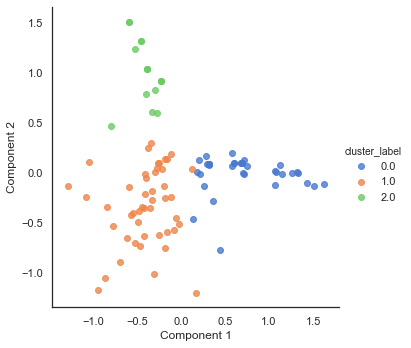

In [20]:
#Plot data with seaborn
ax = sns.lmplot(data=df_pca, x='x', y='y', hue='cluster_label',
               fit_reg=False, legend=True, legend_out=True)
_ = ax.set_axis_labels("Component 1", "Component 2")
# _ = plt.scatter(df_pca['x'], df_pca['y'], c=df_pca['cluster_label'], edgecolors='k')
# _ = plt.xlabel('Component 1')
# _ = plt.ylabel('Component 2')
# _ = plt.title('PCA Components')

### Answer: ###
Based on the PCA figure, $K$ = 3 is the best choice. The method that most clearly produced this optimal $K$ was the Elbow Method.

In [21]:
df_new = pd.merge_ordered(df_customers, df_pca, how='outer', on='customer_name')

In [23]:
# Add new column: ['is_red']
red_dict = {'Champagne':0, 'Pinot Noir':1, 'Prosecco':0, 'Espumante':1, 'Cabernet Sauvignon':1, 'Malbec':1, 'Merlot':1,
           'Pinot Grigio':0, 'Chardonnay':0}
df_new['is_red'] = df_new['varietal']
df_new.replace({'is_red':red_dict}, inplace=True)

# Add new columm: ['continent']
continent_dict = {'France':0, 'Australia':1, 'Chile':2, 'Oregon':3, 'South Africa':4, 'Italy':0, 'Germany':0, 'California':3
                 , 'New Zealand':1}
df_new['continent'] = df_new['origin']
df_new.replace({'continent':continent_dict}, inplace=True)

In [24]:
df_new.groupby(['cluster_label']).varietal.value_counts()
df_new.groupby('cluster_label').campaign.value_counts()
df_new.groupby('cluster_label').origin.value_counts()
df_new.groupby('cluster_label').is_red.value_counts()
df_new.groupby('cluster_label').continent.value_counts()
df_new.groupby("cluster_label")[['is_red','min_qty', 'discount', 'past_peak']].mean()

cluster_label  varietal          
0.0            Champagne             36
               Pinot Noir            25
               Prosecco              18
               Espumante             14
               Cabernet Sauvignon     8
               Malbec                 7
               Merlot                 4
               Pinot Grigio           4
               Chardonnay             1
1.0            Champagne             29
               Espumante             20
               Prosecco              19
               Cabernet Sauvignon    18
               Malbec                16
               Merlot                13
               Pinot Noir            13
               Pinot Grigio          10
               Chardonnay             9
2.0            Champagne             14
               Malbec                 9
               Espumante              6
               Pinot Noir             6
               Prosecco               5
               Cabernet Sauvignon     4
      

cluster_label  campaign 
0.0            March        21
               December     15
               August       13
               October      13
               July         11
               May          10
               February      9
               January       7
               September     7
               November      6
               June          4
               April         1
1.0            March        23
               December     17
               June         13
               October      13
               July         12
               November     12
               April        11
               August       11
               February     11
               May          11
               September     7
               January       6
2.0            December      9
               January       7
               August        6
               March         6
               November      5
               April         4
               October       4
              

cluster_label  origin      
0.0            France          47
               Australia       20
               Italy           10
               Germany          9
               Oregon           9
               Chile            8
               South Africa     7
               California       4
               New Zealand      3
1.0            France          52
               Chile           22
               Australia       15
               Oregon          14
               South Africa    13
               Italy           11
               New Zealand      8
               California       7
               Germany          5
2.0            France          27
               California       5
               Chile            5
               South Africa     5
               Australia        4
               Oregon           3
               Italy            2
               New Zealand      2
               Germany          1
Name: origin, dtype: int64

cluster_label  is_red
0.0            0         59
               1         58
1.0            1         80
               0         67
2.0            1         28
               0         26
Name: is_red, dtype: int64

cluster_label  continent
0.0            0            66
               1            23
               3            13
               2             8
               4             7
1.0            0            68
               1            23
               2            22
               3            21
               4            13
2.0            0            30
               3             8
               1             6
               2             5
               4             5
Name: continent, dtype: int64

,is_red,min_qty,discount,past_peak
cluster_label,,,,
0.0,0.495726,58.358974,60.581197,0.188034
1.0,0.544218,57.714286,58.775510,0.183673
2.0,0.518519,54.888889,58.981481,0.129630


### Answer: ###
Quantitatively, the following patterns can be seen in the different customer groups:
- March campaigns are the most successful with customers in Groups 0 and 2. Maybe customers in these groups are more inclined to celebrate St. Patrick's Day.
- Across all groups, the white wine varieties are the biggest sellers. Customers in Group 1 are slightly more inclined to purchase red varieties than other groups.
- Across all groups, the European wines are the biggest sellers. Chilean wines are mostly purchased by Group 2. Australian wines are purchased mostly by Groups 0 and 2.
- Customers in Group 1 like to buy in smaller quantities, those in Group 2 like to buy in larger quantities, and those in Group 0 fall in between.
- Customers in Group 2 are the most willing to buy wine that is past its peak and those in Group 1 are least likely to do so.

Let's see if we can determine any patterns visually.

In [25]:
#Convert ['campiagn'] to numerical
campaign_dict = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9,'October':10, 'November':11, 'December':12}
df_new.replace({'campaign':campaign_dict}, inplace=True)

#Convert ['varietal'] to numerical
df_new['varietal'].value_counts()
varietal_dict = {'Champagne':1, 'Pinot Noir':2, 'Prosecco':3, 'Espumante':4, 'Cabernet Sauvignon':5, 'Malbec':6, 'Merlot':7, 'Pinot Grigio':8, 'Chardonnay':9}
df_new.replace({'varietal':varietal_dict}, inplace=True)

#Convert ['origin'] to numerical
df_new['origin'].value_counts()
origin_dict = {'France':0, 'Australia':1, 'Chile':2, 'Oregon':3, 'South Africa':4, 'Italy':5, 'Germany':6, 'California':7, 'New Zealand':8}
df_new.replace({'origin':origin_dict}, inplace=True)

Champagne             81
Pinot Noir            44
Prosecco              43
Espumante             40
Malbec                32
Cabernet Sauvignon    32
Merlot                20
Pinot Grigio          17
Chardonnay            15
Name: varietal, dtype: int64

France          128
Australia        39
Chile            37
Oregon           26
South Africa     25
Italy            24
Germany          16
California       16
New Zealand      13
Name: origin, dtype: int64

In [26]:
df_new.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            314, 315, 316, 317, 318, 319, 320, 321, 322, 323],
           dtype='int64', length=324)

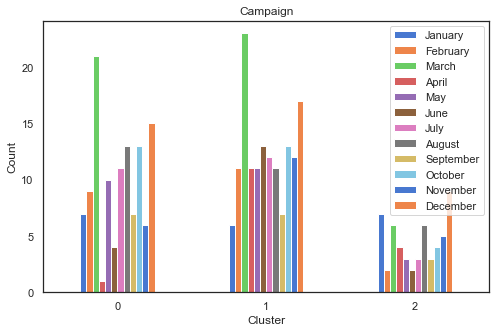

In [27]:
_ = pd.crosstab(df_new['cluster_label'], df_new['campaign']).plot(kind='bar', figsize=(8,5))
_ = plt.title('Campaign')
_ = plt.xlabel('Cluster')
_ = plt.xticks(range(0,3), ('0', '1', '2'), rotation=0) 
_ = plt.ylabel('Count')
_ = plt.legend(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November','December'])

This plot shows that Groups 0 and 1 purchase the most during the March campaign. Group 2 seems to prefer the December campaign. The December campaign is also popular with Groups 0 and 1. The April campaign seems unpopular with Group 0.

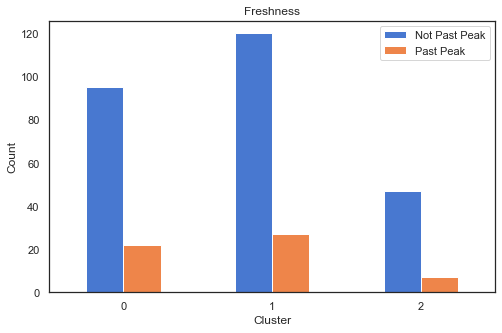

In [28]:
_ = pd.crosstab(df_new['cluster_label'], df_new['past_peak']).plot(kind='bar', figsize=(8,5))
_ = plt.title('Freshness')
_ = plt.xlabel('Cluster')
_ = plt.xticks(range(0,3), ('0', '1', '2'), rotation=0) 
_ = plt.ylabel('Count')
_ = plt.legend(['Not Past Peak', 'Past Peak'])

The plot shows that all three customer groups purchase more fresh wine than wine past its peak.

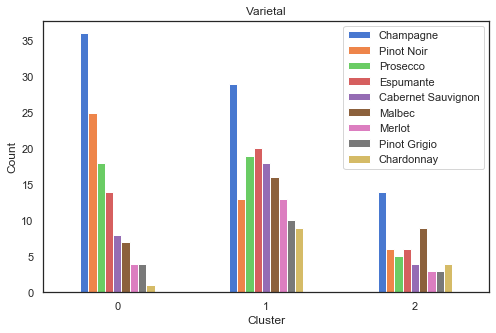

In [29]:
_ = pd.crosstab(df_new['cluster_label'], df_new['varietal']).plot(kind='bar', figsize=(8,5))
_ = plt.title('Varietal')
_ = plt.xlabel('Cluster')
_ = plt.xticks(range(0,3), ('0', '1', '2'), rotation=0) 
_ = plt.ylabel('Count')
_ = plt.legend(['Champagne', 'Pinot Noir', 'Prosecco', 'Espumante', 'Cabernet Sauvignon', 'Malbec', 'Merlot', 'Pinot Grigio', 'Chardonnay'])

This plot shows that champagne is the most popular variety across all three groups. Group 0 also responds well to Pinot Noir promotions but does not purchase much Chardonnay.

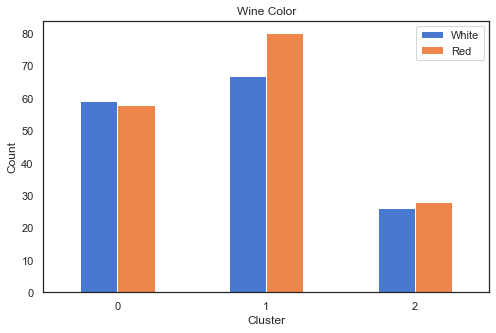

In [30]:
_ = pd.crosstab(df_new['cluster_label'], df_new['is_red']).plot(kind='bar', figsize=(8,5))
_ = plt.title('Wine Color')
_ = plt.xlabel('Cluster')
_ = plt.xticks(range(0,3), ('0', '1', '2'), rotation=0) 
_ = plt.ylabel('Count')
_ = plt.legend(['White', 'Red'])

This plot shows that all three customer groups generally purchase more red wine than white.  

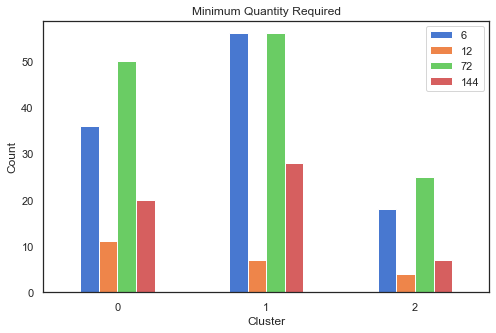

In [31]:
_ = pd.crosstab(df_new['cluster_label'], df_new['min_qty']).plot(kind='bar', figsize=(8,5))
_ = plt.title('Minimum Quantity Required')
_ = plt.xlabel('Cluster')
_ = plt.xticks(range(0,3), ('0', '1', '2'), rotation=0) 
_ = plt.ylabel('Count')
_ = plt.legend(['6', '12', '72', '144'])

This plot shows that there is not much noticeable different between quantity amont all the groups.

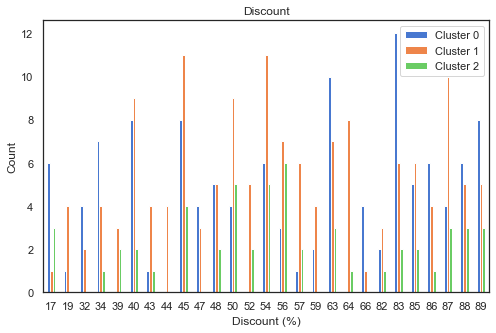

In [32]:
_ = pd.crosstab(df_new['discount'], df_new['cluster_label']).plot(kind='bar', figsize=(8,5))
_ = plt.title('Discount')
_ = plt.xlabel('Discount (%)')
_ = plt.xticks(rotation=0) 
_ = plt.ylabel('Count')
_ = plt.legend(['Cluster 0', 'Cluster 1', 'Cluster 2'])

This plot shows that there is a wide range of responses among the groups when it comes to discounts of the campaign.

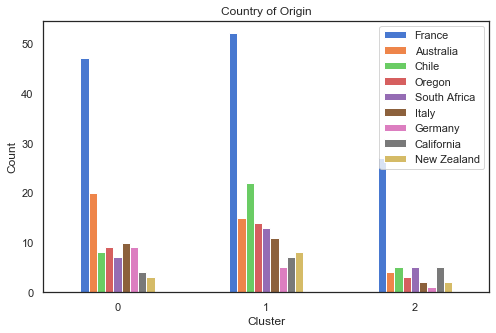

In [33]:
_ = pd.crosstab(df_new['cluster_label'], df_new['origin']).plot(kind='bar', figsize=(8,5))
_ = plt.title('Country of Origin')
_ = plt.xlabel('Cluster')
_ = plt.xticks(range(0,3), ('0', '1', '2'), rotation=0) 
_ = plt.ylabel('Count')
_ = plt.legend(['France', 'Australia', 'Chile', 'Oregon', 'South Africa', 'Italy', 'Germany', 'California', 'New Zealand'])

This plot shows that all three customer groups purchase mostly French wine. Group 0 also likes Australian wine, whereas group 2 also likes Chilean wine.

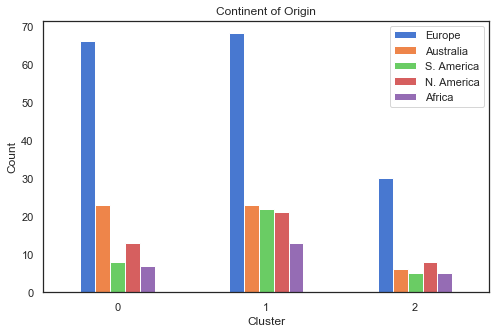

In [34]:
_ = pd.crosstab(df_new['cluster_label'], df_new['continent']).plot(kind='bar', figsize=(8,5))
_ = plt.title('Continent of Origin')
_ = plt.xlabel('Cluster')
_ = plt.xticks(range(0,3), ('0', '1', '2'), rotation=0) 
_ = plt.ylabel('Count')
_ = plt.legend(['Europe', 'Australia', 'S. America', 'N. America', 'Africa'])

This plot shows that while each group mostly buys wine from Europe, Group 0 also likes Australian wine, and Group 3 like Australian, South American, and North American wines almost equally.

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

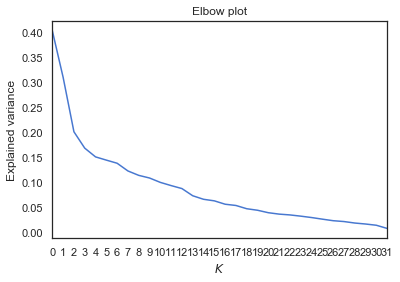

In [36]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)

# Do the rest on your own :)
_ = plt.plot(pca.explained_variance_)
_ = plt.xlabel('$K$')
_ = plt.xticks(range(0,33,1))
_ = plt.xlim([0,31])
_ = plt.ylabel('Explained variance')
_ = plt.title('Elbow plot')

Based on this figure, a possible value for the optimal number of dimensions is 2 or 4.

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [44]:
# Your turn
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import AffinityPropagation
model = AffinityPropagation()
labels = model.fit_predict(x_cols)
print('Clusters labels :{}'.format(set(labels)))
print('Silhouette score for Affinity Propagation Clustering = {}'.format(silhouette_score(x_cols,labels)))

Clusters labels :{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
Silhouette score for Affinity Propagation Clustering = 0.1300214652665857


In [45]:
from sklearn.cluster import SpectralClustering
clustering = SpectralClustering(n_clusters=2,assign_labels="discretize",random_state=0)
labels = clustering.fit_predict(x_cols)
print('Clusters labels :{}'.format(set(labels)))
print('Silhouette score for Spectral Clustering = {}'.format(silhouette_score(x_cols,labels)))

Clusters labels :{0, 1}
Silhouette score for Spectral Clustering = 0.07831842901499375


In [46]:
from sklearn.cluster import AgglomerativeClustering
Agg = AgglomerativeClustering()
labels = Agg.fit_predict(x_cols)
print('Clusters labels :{}'.format(set(labels)))
print('Silhouette score for Agglomerative Clustering = {}'.format(silhouette_score(x_cols,labels)))

Clusters labels :{0, 1}
Silhouette score for Agglomerative Clustering = 0.0790946165526936


In [47]:
from sklearn.cluster import DBSCAN
DBS = DBSCAN()
labels = DBS.fit_predict(x_cols)
print('Clustering labels :{}'.format(set(labels)))

Clustering labels :{-1}


The last algorithm, DBSCAN did not work on the dataset since it returned a negative result. For the other three models, we calculated the silhouette_score, with higher score being the better. Out of the remaining three models, Affinity Propagation has the highest score and performs the best. 